In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Install necessary Libraries

In [2]:
# Installing Libraries


! pip install transformers -q
! pip install annoy -q

# Importing Libraries


from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
import numpy as np
import string
import re
from tqdm.auto import tqdm
tqdm.pandas()

import _pickle as cPickle

# Checking to see if CUDA is available if so storing details in device


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

     |████████████████████████████████| 3.8 MB 4.3 MB/s 
     |████████████████████████████████| 67 kB 3.6 MB/s 
     |████████████████████████████████| 895 kB 45.5 MB/s 
     |████████████████████████████████| 596 kB 51.0 MB/s 
     |████████████████████████████████| 6.5 MB 39.3 MB/s 
     |████████████████████████████████| 646 kB 4.4 MB/s 


In [3]:
! pip3 install syntok -q
! pip install -U sentence-transformers -q
! pip install langdetect -q

     |████████████████████████████████| 79 kB 2.9 MB/s 
     |████████████████████████████████| 1.2 MB 9.3 MB/s 
     |████████████████████████████████| 981 kB 4.3 MB/s 


In [4]:
import syntok.segmenter as segmenter
import torch 
from sentence_transformers import SentenceTransformer ,  util
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from langdetect import detect
import pickle

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  """


# Define Variables and Functions

In [5]:
#Mean Pooling - Take attention mask into account for correct averaging


def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [6]:
# Function to generate embeddings

def get_embedings(model,sentences):
  model.to(device)   ##to run on gpu
  sent_len=len(sentences)
  limit=250
  if sent_len>limit:
    sentence_embeddings=[]
    for i in range(0,sent_len,limit):
      j=i+limit
      if j>sent_len:
        j=sent_len
      #Tokenize sentences   Here tokenize and genrtae sentence embeddings in 10000 chunk 
      encoded_input = tokenizer(sentences[i:j], padding=True, truncation=True, return_tensors='pt')
      encoded_input.to(device)
      #Compute token embeddings
      with torch.no_grad():
          model_output = model(**encoded_input)
      #Perform pooling. In this case, mean pooling
      sentence_embeddings1 = mean_pooling(model_output, encoded_input['attention_mask'])
      sentence_embeddings = sentence_embeddings+sentence_embeddings1.tolist()
  else :
      encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
      encoded_input.to(device)
      #Compute token embeddings
      with torch.no_grad():
          model_output = model(**encoded_input)
      #Perform pooling. In this case, mean pooling
      sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
      sentence_embeddings = sentence_embeddings.tolist()
  print(len(sentence_embeddings))
  return sentence_embeddings

In [7]:
# Defining the model here, we use a model that is fine tuned on News articles
model_name = "/content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Resources/go_model"

# Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at /content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Resources/go_model were not used when initializing DistilBertModel: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
# def get_mean_pooling_emb(sentences):
#   tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/NLP_notebooks/Emotional_embeddings/go_model")
#   model = AutoModel.from_pretrained("/content/drive/MyDrive/NLP_notebooks/Emotional_embeddings/go_model")
#   encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=128, return_tensors='pt')
#   #Compute token embeddings
#   with torch.no_grad():
#       model_output = model(**encoded_input)

#   sentence_embeddings_raw = mean_pooling(model_output, encoded_input['attention_mask'])
#   sentence_embeddings = sentence_embeddings_raw.tolist()

#   return sentence_embeddings


# Read Data

In [ ]:
df = pd.read_csv(r"/content/drive/Shareddrives/FYP - knk/Resources/NRC-Emotion-Intensity-Lexicon-v1.txt",  delimiter = "\t")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9921 entries, 0 to 9920
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word                     9921 non-null   object 
 1   emotion                  9921 non-null   object 
 2   emotion-intensity-score  9921 non-null   float64
dtypes: float64(1), object(2)
memory usage: 232.6+ KB


In [ ]:
df.head()

,word,emotion,emotion-intensity-score
0,outraged,anger,0.964
1,brutality,anger,0.959
2,hatred,anger,0.953
3,hateful,anger,0.940
4,terrorize,anger,0.939


In [ ]:
df['emotion'].unique()

array(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness',
       'surprise', 'trust'], dtype=object)

# Input Embeddings - Sentence Transformer

In [ ]:
# Import the sentence transformer model
model = SentenceTransformer('/content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Resources/go_model', device = 'cuda')

Some weights of the model checkpoint at /content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Resources/go_model were not used when initializing DistilBertModel: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def generate_embeddings(sentences, num):
  result = []
  num_of_sentences = len(sentences)
  for i in range(0, num_of_sentences, num):
    embeddings = model.encode(sentences[i:i+num])
    embeddings=[torch.from_numpy(item) for item in embeddings]
    result.extend(embeddings)
    print("Sentences Done: "+str(i+num))
  return result

In [ ]:
sent = df['word'].tolist()

print(len(sent))

9921


In [ ]:
emb = generate_embeddings(sent, 3500)

Sentences Done: 3500
Sentences Done: 7000
Sentences Done: 10500


In [ ]:
df['input_embeddings'] = emb

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9921 entries, 0 to 9920
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word                     9921 non-null   object 
 1   emotion                  9921 non-null   object 
 2   emotion-intensity-score  9921 non-null   float64
 3   input_embeddings         9921 non-null   object 
dtypes: float64(1), object(3)
memory usage: 310.2+ KB


In [ ]:
df.head()

,word,emotion,emotion-intensity-score,input_embeddings,input
0,outraged,anger,0.964,"[tensor(0.6452), tensor(-1.0939), tensor(-1.21...","[0.6451590657234192, -1.093907356262207, -1.21..."
1,brutality,anger,0.959,"[tensor(0.0175), tensor(-0.8108), tensor(-1.46...","[0.017451053485274315, -0.8107596039772034, -1..."
2,hatred,anger,0.953,"[tensor(0.5489), tensor(-0.3985), tensor(-1.27...","[0.5489328503608704, -0.39848804473876953, -1...."
3,hateful,anger,0.940,"[tensor(0.6184), tensor(-0.3299), tensor(-1.07...","[0.6184238791465759, -0.32990288734436035, -1...."
4,terrorize,anger,0.939,"[tensor(0.0632), tensor(-0.0506), tensor(-1.34...","[0.06317409873008728, -0.05061223357915878, -1..."


In [ ]:
def change_to_list(embedding):
  input = embedding.tolist()
  return input
  
df['input'] = df['input_embeddings'].apply(change_to_list)

In [ ]:
type(df['input'][0])

list

In [ ]:
df.drop(['input_embeddings'], axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9921 entries, 0 to 9920
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word                     9921 non-null   object 
 1   emotion                  9921 non-null   object 
 2   emotion-intensity-score  9921 non-null   float64
 3   input                    9921 non-null   object 
dtypes: float64(1), object(3)
memory usage: 310.2+ KB


In [ ]:
df.to_csv(r"/content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Resources/NRC Emotion Intensity_V4.csv", index=False ,encoding='utf-8')

# Input Embeddings - transformer

In [ ]:
words = df['word'].values.tolist()
print(words)

['outraged', 'brutality', 'hatred', 'hateful', 'terrorize', 'infuriated', 'violently', 'furious', 'enraged', 'furiously', 'screwyou', 'murderer', 'fury', 'execution', 'angered', 'savagery', 'slaughtering', 'veryangry', 'assassinate', 'fuckoff', 'annihilation', 'rage', 'loathe', 'damnation', 'roadrage', 'fucktard', 'homicidal', 'furor', 'hostile', 'annihilate', 'murder', 'raging', 'sopissed', 'pissed', 'rape', 'explosive', 'obliterated', 'vengeful', 'ferocious', 'infuriates', 'killing', 'combative', 'gofuckyourself', 'vengeance', 'wrath', 'torment', 'vicious', 'threatening', 'massacre', 'bloodthirsty', 'abhorrent', 'pissoff', 'fighting', 'annihilated', 'attacking', 'angriest', 'bloodshed', 'smite', 'brawl', 'assault', 'assassination', 'strangle', 'explode', 'malicious', 'tirade', 'hostility', 'loathsome', 'attack', 'hell', 'murderous', 'malice', 'terrorism', 'beating', 'pissingmeoff', 'desecration', 'outrage', 'irate', 'tumultuous', 'destroying', 'violent', 'stab', 'infuriate', 'slaught

In [ ]:
# Generate Embeddings
emotion_embeddings = get_embedings(model, words)

9921


In [ ]:
df['embedding'] = emotion_embeddings

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9921 entries, 0 to 9920
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word                     9921 non-null   object 
 1   emotion                  9921 non-null   object 
 2   emotion-intensity-score  9921 non-null   float64
 3   embedding                9921 non-null   object 
dtypes: float64(1), object(3)
memory usage: 310.2+ KB


In [ ]:
df.head()

,word,emotion,emotion-intensity-score,embedding
0,outraged,anger,0.964,"[0.645158588886261, -1.0939077138900757, -1.21..."
1,brutality,anger,0.959,"[0.01745154894888401, -0.8107593059539795, -1...."
2,hatred,anger,0.953,"[0.5489322543144226, -0.3984881341457367, -1.2..."
3,hateful,anger,0.940,"[0.6184241771697998, -0.3299030661582947, -1.0..."
4,terrorize,anger,0.939,"[0.06317470222711563, -0.0506117045879364, -1...."


In [ ]:
type(df['embedding'][0][0])

float

In [ ]:
len(df['embedding'][0])

768

In [ ]:
df.to_csv(r"/content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Resources/NRC Emotion Intensity_GO_model.csv", index=False ,encoding='utf-8')

#EDA

In [9]:
import pandas as pd
# import matplotlib
import matplotlib.pyplot as plt
# import seaborn
import seaborn as sns
%matplotlib inline

In [22]:
def visualize_embs(labels,embs,words):
    #fourteen 2 colors
    label_color_dict = {'anticipation':'green','anger':'red','disgust':'orange',
                        'fear':'blue','sadness':'gray','joy':'yellow','surprise':'pink',
                        'trust':'tan','input':'cyan'}

    # label_color_dict = {'anticipation':'green','anger':'red','disgust':'red',
    #                     'fear':'red','sadness':'red','joy':'green','surprise':'green',
    #                     'trust':'green'}
    X = embs
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    # inverse_transform_dataset = pca.inverse_transform(result)
    # MSE_score = ((X-inverse_transform_dataset)**2).sum(axis=1)
    # final_largest = sorted(range(len(MSE_score)), key=lambda x: MSE_score[x])[-50:]
    # print(final_largest)
    # print(result)

    filtered_words = []
    filtered_emb = []
    filtered_label = []
    for i,j in enumerate(result):
        if(j[0] < 1 and labels[i] in ['joy','anticipation','trust','surprise','input']):
            filtered_emb.append(j)
            filtered_label.append(labels[i])
    
            filtered_words.append(words[i])
    
        if (j[0] > -1 and labels[i] in ['sadness','disgust','anger','fear','input']):
            filtered_emb.append(j)
            filtered_label.append(labels[i])
            filtered_words.append(words[i])

    result = np.array([x for x in filtered_emb])
    labels = filtered_label
    words = filtered_words
    # print(result)

    cvec = [label_color_dict[label] for label in labels]


    # Create the scatter plot
    plt.figure(figsize=(8,8))
    plt.scatter(result[:,0], result[:,1],c=cvec, edgecolor='', alpha=0.5)

    annotations= words
    X = result[:,0]
    Y = result[:,1]
    print(annotations)

    for i, words in enumerate(annotations):
      if(words[i] == 'input'):
        plt.annotate(label, (X[i], Y[i]))

    # Add the axis labels
    plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
    plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100))
    plt.title('Embedding Space')
    # Done
    plt.show()

In [11]:
import pandas as pd
import re               # Obtain expressions
from gensim.models import Word2Vec    #Import gensim Word2Fec
from sklearn.decomposition import PCA #Grab PCA functions
import numpy as np
#Plot helpers
import matplotlib
import matplotlib.pyplot as plt
#Enable matplotlib to be interactive (zoom etc)

#plot the vocabulary
import ast
import random

In [19]:
vocab_df = pd.read_csv(r"/content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Resources/NRC Emotion Intensity_GO_model.csv")

In [ ]:
# vocab_df=df

In [20]:
vocab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9921 entries, 0 to 9920
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word                     9921 non-null   object 
 1   emotion                  9921 non-null   object 
 2   emotion-intensity-score  9921 non-null   float64
 3   embedding                9921 non-null   object 
dtypes: float64(1), object(3)
memory usage: 310.2+ KB


In [ ]:
vocab_df.head()

,word,emotion,emotion-intensity-score,embedding
0,abacus,trust,0.406,"[-0.3572045564651489, -0.27242910861968994, 0...."
1,abandoned,sadness,0.828,"[-0.5577418804168701, 0.015890369191765785, -0..."
2,abbot,trust,0.438,"[-0.5629075765609741, -0.4061563313007355, -0...."
3,aberration,disgust,0.531,"[-0.5287905931472778, -0.1950991153717041, -0...."
4,abhor,anger,0.816,"[-0.6878913640975952, 0.1946220099925995, -1.3..."


In [ ]:
vocab_df = vocab_df.loc[vocab_df['emotion'].isin(['anger','fear','disgust','sadness','joy','surprise','anticipation'])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


['outraged', 'brutality', 'hatred', 'hateful', 'terrorize', 'infuriated', 'violently', 'furious', 'enraged', 'screwyou', 'murderer', 'fury', 'angered', 'savagery', 'slaughtering', 'veryangry', 'assassinate', 'fuckoff', 'annihilation', 'rage', 'loathe', 'damnation', 'fucktard', 'homicidal', 'furor', 'hostile', 'annihilate', 'murder', 'raging', 'pissed', 'rape', 'obliterated', 'vengeful', 'ferocious', 'infuriates', 'killing', 'gofuckyourself', 'vengeance', 'wrath', 'torment', 'vicious', 'threatening', 'massacre', 'bloodthirsty', 'abhorrent', 'pissoff', 'annihilated', 'angriest', 'bloodshed', 'smite', 'brawl', 'assault', 'assassination', 'strangle', 'explode', 'malicious', 'tirade', 'hostility', 'loathsome', 'attack', 'hell', 'murderous', 'malice', 'terrorism', 'pissingmeoff', 'desecration', 'outrage', 'irate', 'tumultuous', 'destroying', 'violent', 'infuriate', 'slaughter', 'abomination', 'obliterate', 'dumbbitch', 'detest', 'prick', 'cruelty', 'horrid', 'rampage', 'rabid', 'torture', 's

IndexError: ignored

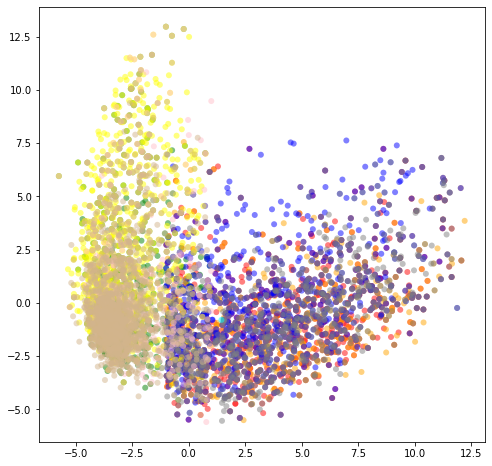

In [23]:
total_words = vocab_df['word'].tolist()
total_words.append('NEWS ITEM')
words = total_words
# embeddings = eda['embedding'].tolist()


embedd_news = [-0.5919699668884277, -0.3270726501941681, 0.10148581862449646, 0.6891396641731262, -0.6119957566261292, -0.2094128429889679, 0.6009973287582397, 0.6094540357589722, -0.5507127046585083, 0.508753776550293, 0.005760223604738712, -0.44100421667099, -0.43556657433509827, -0.5760570764541626, -0.18614983558654785, -0.7707829475402832, 0.23815864324569702, -0.2268608659505844, -0.7382434606552124, -0.36120468378067017, 0.05674410238862038, 0.3360074758529663, 0.0021345801651477814, -0.5356011390686035, 0.10184471309185028, 0.1111571416258812, -0.19259420037269592, 0.822379469871521, 0.7708052396774292, -0.16490140557289124, -0.29464924335479736, 0.13063903152942657, 0.11077871918678284, -0.03044365718960762, -0.4014442563056946, -0.6039606928825378, 0.09794454276561737, 0.08553873002529144, 0.4285934567451477, -0.04946625605225563, 0.08532935380935669, -0.636039674282074, -0.05610320717096329, 0.04098411649465561, -0.4043087959289551, 0.2994321584701538, 0.7199816703796387, 0.7240045666694641, -0.9247738122940063, -0.10076639801263809, -0.41774871945381165, -0.11759144067764282, -0.657279372215271, 0.2104843407869339, -0.04249761626124382, -0.04271808639168739, 0.003373761661350727, -0.2183012068271637, -0.7359071373939514, -0.8490350246429443, 0.04658794403076172, -0.41566532850265503, -0.04108511656522751, -0.48854225873947144, 0.7061911225318909, 0.4071953296661377, -0.8493058085441589, 0.017710469663143158, -0.027649160474538803, -0.4674031734466553, -0.47150659561157227, 0.07429720461368561, 0.159945547580719, 0.20573756098747253, -0.14676135778427124, -0.06491103768348694, -0.38426071405410767, 0.769347071647644, 0.8577497005462646, -0.5248847603797913, -0.26622673869132996, -0.8292644023895264, -0.15328872203826904, 0.3158797025680542, -0.09928292781114578, -0.6308172941207886, 0.5412209630012512, -0.35349953174591064, -0.03096257895231247, 0.19164058566093445, -0.1299569457769394, -0.4394527077674866, 0.6784746646881104, -0.030349720269441605, -0.031685661524534225, 0.28401046991348267, -0.255077064037323, 0.021183716133236885, 0.017203636467456818, -0.025141306221485138, -0.8025413751602173, -0.8730841875076294, -0.34259122610092163, 0.6478111743927002, -0.37150537967681885, -0.6050775647163391, 0.030065828934311867, 0.8102003335952759, 0.22664019465446472, 0.5539159774780273, 0.006085245404392481, 0.5892435312271118, -0.5742888450622559, 0.1370963156223297, -0.6187841296195984, -0.3821207880973816, 0.05521104484796524, -0.12810370326042175, 0.1184440404176712, 0.2124074399471283, 1.062163233757019, 0.47404342889785767, 0.5356351137161255, 0.1342548131942749, 0.16562536358833313, 0.32888638973236084, -0.7138998508453369, 0.06749504804611206, 0.5708074569702148, -0.24797824025154114, 0.13342563807964325, 0.41575223207473755, 0.10215636342763901, 0.1282864511013031, -0.2715613842010498, -0.4671538472175598, -0.11231096088886261, 0.5402284264564514, -0.44705867767333984, 0.26810896396636963, 0.09953515976667404, -0.7540149688720703, 0.2224229872226715, 0.3254396319389343, 1.2657884359359741, -0.4802902936935425, 0.3714006841182709, -0.5235414505004883, 0.8030033707618713, 0.03783915191888809, 0.5734796524047852, 0.5267202854156494, 0.07360263913869858, -1.0050251483917236, -0.36481577157974243, 0.19394364953041077, -0.20064663887023926, -0.8192654848098755, -0.7734492421150208, -0.8186812996864319, 0.6766360998153687, -0.23693910241127014, -0.5569612979888916, -0.6537377238273621, 0.4142189919948578, 0.09790660440921783, -0.4983515739440918, 0.06752347946166992, 0.4100019633769989, 0.3044928014278412, 0.259727418422699, -0.40325647592544556, 0.46533554792404175, 1.0935890674591064, 0.013002140447497368, -0.6455873250961304, 0.26075446605682373, -0.38781028985977173, 0.7053665518760681, 0.49930477142333984, -0.23857168853282928, 0.6854747533798218, -0.6454814076423645, 1.1366344690322876, 0.32705697417259216, -0.34150463342666626, 0.2378847897052765, 0.15629349648952484, 0.903372049331665, -0.21228599548339844, -0.14827878773212433, 0.012191359885036945, -0.4873926639556885, 0.7724328637123108, 0.32663586735725403, -0.13841186463832855, -0.6378825306892395, 0.41310787200927734, -0.5428711175918579, -0.1375928670167923, 0.43316352367401123, 0.11908680945634842, 1.0381110906600952, 0.5103957056999207, -0.4177773594856262, -0.25579407811164856, 0.7305386066436768, -0.42809349298477173, -0.1732887625694275, 0.8256124258041382, -0.5079832673072815, 0.0692920982837677, 0.5579409599304199, -0.6374889612197876, -0.7342919707298279, 0.05496470630168915, 0.18189114332199097, -0.4821241796016693, 0.4721793830394745, 0.3672998249530792, 0.6262727975845337, 0.526448667049408, -0.6616895794868469, 0.7287299633026123, -0.06478714942932129, 0.5153933763504028, -0.13791561126708984, -1.0006053447723389, 0.4309368133544922, 0.6763007640838623, 0.1042853593826294, 0.5412307977676392, 0.5357369184494019, 0.01637922041118145, -0.7275313138961792, -0.830438494682312, 0.7927396893501282, 0.68462073802948, -0.6592273116111755, -0.5731779336929321, -0.059469159692525864, 1.1707944869995117, -0.042864952236413956, 0.47674378752708435, -0.8575765490531921, -0.4699404835700989, -0.08125607669353485, -0.7736352682113647, -0.1291923075914383, -0.5097563862800598, -0.18747515976428986, -0.48310109972953796, 0.40073996782302856, -0.13416501879692078, -0.5626452565193176, -0.17249755561351776, 0.12447324395179749, -0.4749014675617218, -0.2913457751274109, 0.2808239459991455, 0.28958192467689514, 0.41758882999420166, 0.021638689562678337, 0.49908554553985596, -0.5684128999710083, -0.40448451042175293, -0.17374619841575623, 0.622080385684967, 0.26497772336006165, 0.10555645823478699, 0.1754779815673828, 0.2185169905424118, -0.9124669432640076, 0.09828417748212814, 0.055075403302907944, -0.5750004649162292, 0.3592325448989868, -0.684942364692688, 0.6787352561950684, -0.7797777652740479, 0.2938001751899719, 0.9562541842460632, 0.3020989000797272, -0.9791264533996582, 0.6332895755767822, -1.0338387489318848, -0.5185031294822693, -0.23211736977100372, -0.3107964098453522, 0.08193286508321762, 0.40373924374580383, 0.16927188634872437, -0.24816365540027618, -0.3777194917201996, 0.004504815675318241, -0.12624400854110718, -0.6947290897369385, -0.14563241600990295, 0.02825184352695942, 0.10530051589012146, -0.5570357441902161, -0.01673830673098564, 1.178867220878601, 0.19779828190803528, 0.18606053292751312, -0.32953453063964844, -0.15713006258010864, -0.0035524535924196243, -0.3071027994155884, 0.24027755856513977, 0.3023415207862854, 0.0875038355588913, 0.6319907903671265, 0.44165247678756714, 0.3263026475906372, 0.6127220392227173, 0.15558461844921112, 0.22406849265098572, 0.5470542311668396, -0.6298830509185791, -0.5090901851654053, 1.0858056545257568, 0.22535768151283264, 0.024276141077280045, -0.48053178191185, -0.24278241395950317, 0.1730051338672638, 0.8384348154067993, 0.1756201684474945, -0.20799127221107483, -0.34871047735214233, -0.20268034934997559, -0.3215462565422058, 0.5917376279830933, 0.44112008810043335, -0.3862813115119934, 0.02141929417848587, -0.5509216785430908, -0.20300917327404022, -0.017075249925255775, 0.37746748328208923, 0.13357050716876984, 0.044823214411735535, -0.460188627243042, -0.5488793253898621, -1.0436105728149414, -0.702713131904602, -0.22795134782791138, -0.35023921728134155, 0.20216435194015503, -0.36298316717147827, -0.8178054690361023, -0.1760074943304062, -0.07625135779380798, 0.044251032173633575, -0.45942163467407227, -0.10249043256044388, 0.2040238380432129, 0.8657879829406738, -0.4431026875972748, -0.30298924446105957, -0.15677094459533691, -0.4014364778995514, -0.28556257486343384, 0.2378852665424347, 0.41660839319229126, 0.15686962008476257, 0.1308632493019104, -0.23337747156620026, -0.32967227697372437, -0.3262343108654022, 0.5951619148254395, -0.7787380218505859, -0.4172564744949341, -0.37763482332229614, 0.29017215967178345, 0.28587114810943604, 0.2465936690568924, -0.3400358259677887, -0.6895677447319031, -0.09043113142251968, 0.4875621795654297, -0.0248098224401474, 0.8474727869033813, 0.3353908061981201, 0.3568001389503479, 0.7623773813247681, 0.005778659135103226, -0.4535983204841614, -0.13165582716464996, -0.0015867603942751884, 0.4672013521194458, -0.08013065159320831, -0.6933354139328003, -0.380700945854187, 0.14804086089134216, -0.07446479797363281, 0.4457075297832489, 0.6135432124137878, 0.2256469875574112, 0.10418117046356201, 0.10523083806037903, 0.7395341992378235, -0.11645004898309708, 0.6422789096832275, 0.016052020713686943, -0.26285669207572937, -0.13489127159118652, -0.5627796053886414, -0.22465695440769196, 0.38968712091445923, -0.17856884002685547, 0.04960962012410164, -0.2941548824310303, 0.0764830932021141, 0.004071565344929695, -0.4505801796913147, -0.44221383333206177, -0.32772910594940186, -0.750568151473999, 0.4161829352378845, -0.8300248980522156, 0.7052538990974426, 0.458764910697937, -0.5054576396942139, 0.9668107032775879, -0.7189583778381348, -0.13692015409469604, -0.14833766222000122, 0.3730434775352478, 0.11389376223087311, -0.02090626209974289, -0.4592791795730591, 0.5828500390052795, -0.21103984117507935, 0.5647239685058594, 0.25060415267944336, -0.12156715244054794, -0.010583577677607536, 0.7675198316574097, -0.24818119406700134, -0.5155738592147827, 0.3400053381919861, 0.20537351071834564, 0.18845713138580322, -0.6975015997886658, -0.040271636098623276, -0.8684715032577515, -0.47491782903671265, 0.3415631055831909, -0.3832882046699524, 0.4458659887313843, 0.02758539840579033, 0.046437423676252365, -0.2260756492614746, -0.790345311164856, -0.14296670258045197, -0.12359859049320221, -0.6857089996337891, 0.43942052125930786, 0.29196813702583313, -0.21499323844909668, 0.3362763226032257, -0.07488087564706802, -0.13810934126377106, 0.41663408279418945, -0.9605841636657715, -0.5321686267852783, -0.2981010675430298, 0.4147995710372925, -0.05526363104581833, 0.15573039650917053, -0.5372759699821472, 0.26075536012649536, -0.07209528982639313, -0.39014101028442383, 0.14585234224796295, 0.0456426627933979, -0.07792359590530396, -0.3907615840435028, -0.44504597783088684, -0.513637363910675, 0.004686995409429073, 0.11818840354681015, -0.0997452661395073, 0.2793309688568115, 0.8435936570167542, 0.19281554222106934, 0.29852283000946045, -0.03069290891289711, -1.0088467597961426, 0.0778285413980484, 0.6325653195381165, 0.794564962387085, -0.1648617386817932, -0.4388939142227173, -0.201759934425354, -0.06888912618160248, 0.810135006904602, 0.5167741775512695, -0.8112353086471558, 0.3377836346626282, -0.3238178491592407, -0.5187633633613586, 0.4664645791053772, 0.4830348789691925, -0.41427889466285706, -0.23156537115573883, 0.2957149147987366, 0.11696812510490417, -0.4090427756309509, -0.7713849544525146, 0.05734650045633316, -0.774012565612793, 0.2198568433523178, 0.8425759673118591, 0.21677066385746002, 0.32425791025161743, -0.6601977944374084, -0.44397789239883423, -0.5445588827133179, 0.20045800507068634, 0.6331220865249634, 0.11997563391923904, -0.024878591299057007, -0.024796172976493835, -1.1018098592758179, 0.42092472314834595, -1.0282634496688843, -0.07328563183546066, -0.6385113596916199, -0.5642324090003967, -0.8283277750015259, -0.03171524032950401, 0.5025149583816528, 0.0016462840139865875, -0.24043533205986023, -0.4308658838272095, 0.14687331020832062, 0.08853524178266525, 0.0905875414609909, 0.8825211524963379, 0.2740722894668579, 0.005646505393087864, 0.7657504081726074, -0.6986548900604248, -0.5583503246307373, -0.8886428475379944, -0.875392735004425, -0.37034496665000916, -0.30370721220970154, -0.2275942862033844, -0.17594651877880096, -0.6802115440368652, -0.7422567009925842, -0.2143273651599884, 0.30534517765045166, 0.22366482019424438, -0.7089800238609314, -0.3451951742172241, -0.03025035373866558, -0.8532737493515015, -0.057521991431713104, -0.08292630314826965, 0.38654404878616333, -0.3002775311470032, -0.2150956094264984, -0.2845335006713867, 0.03973256051540375, 0.3883206248283386, -0.36136698722839355, -0.4968363344669342, 0.2639261484146118, 0.34131741523742676, 0.3567298650741577, 0.19927850365638733, -0.2762754559516907, 0.1677366942167282, 0.11576257646083832, -0.23928207159042358, 0.35959377884864807, -0.2413230538368225, 0.35569003224372864, 0.5180253386497498, 0.5350264310836792, -0.7517663836479187, 0.056794069707393646, 0.18268948793411255, -0.4786199927330017, -0.3150070309638977, -0.34563565254211426, 0.7698570489883423, -0.576745867729187, -0.057576753199100494, 0.42272472381591797, 0.38414159417152405, -0.16663992404937744, 0.6555005311965942, -0.23605968058109283, 0.6804850101470947, 0.24017131328582764, 0.0647449940443039, -1.2284762859344482, -0.7875102162361145, 0.3219643235206604, 0.04512184485793114, 0.12146700918674469, -0.32478272914886475, 0.09963899850845337, -0.09474606812000275, -0.25540149211883545, -0.24577942490577698, -0.1982792615890503, 0.3590957522392273, -0.2203672230243683, -0.581417441368103, 0.7029647827148438, 0.41117173433303833, -0.08234008401632309, 0.4266000986099243, -0.12724994122982025, 0.22478273510932922, -0.5676842927932739, -0.6224952936172485, 0.4864876866340637, 0.2951059639453888, 0.2878807783126831, -0.4027940630912781, -0.7076617479324341, -0.724596381187439, 0.47758394479751587, 0.44140613079071045, -0.48305144906044006, -0.08402468264102936, -0.5362557768821716, -0.6020889282226562, -0.08969874680042267, -0.056180182844400406, -0.20920303463935852, 0.5600193738937378, -0.07252020388841629, 0.5226072072982788, 0.27316996455192566, -0.5499162673950195, 0.37176382541656494, 0.7444108724594116, 0.1536700427532196, 0.18258635699748993, 0.8563038110733032, 0.3924397826194763, -0.19079947471618652, 0.45215654373168945, -0.07683954387903214, -0.07286329567432404, -0.2471686601638794, 0.06360240280628204, 0.0654928982257843, 0.8051393032073975, 0.314614474773407, 0.9791312217712402, 0.16849930584430695, -0.5714274048805237, 0.8467105627059937, 0.17049197852611542, -0.2849650979042053, 0.3364415764808655, -0.7287962436676025, 0.14256024360656738, 0.3951718211174011, 0.566715657711029, -0.10605040192604065, -0.44499099254608154, -0.6934380531311035, 0.25839686393737793, 0.5626155734062195, -0.36843058466911316, -0.666961133480072, 0.4630507230758667, -0.39970269799232483, -0.2590647339820862, 0.08254721760749817, -0.18577978014945984, -0.5162339210510254, 1.4442068338394165, 0.9147508144378662, -0.20393267273902893, -0.24284891784191132, -0.21908439695835114, -0.2970215082168579, 0.4876672327518463, 0.12524455785751343, 0.24218550324440002, -1.4439074993133545, -0.11124437302350998, 0.16215983033180237, 0.6560877561569214, -0.1045975387096405, 0.4346942901611328, 0.1356811821460724, 0.035549718886613846, -0.1864573359489441, -0.37592148780822754, -0.33873873949050903, 0.26529306173324585, -0.27472683787345886, 0.6475304365158081, 0.5284560918807983, -0.4772636592388153, 0.49150753021240234, -0.45538097620010376, -0.3767792582511902, 0.6051124930381775, -0.3593549430370331, -0.07451686263084412, -0.4506295621395111, -0.27017831802368164, -0.19481655955314636, -0.07179869711399078, 0.19182181358337402, -0.02927452325820923, -0.14576566219329834, -0.5890829563140869, -0.8068463802337646, 0.4895506501197815, -0.3151097893714905, 0.29600533843040466, 0.20022925734519958, -0.20288050174713135, 0.19872979819774628, -0.4214385747909546, -0.38703644275665283, 0.5410169363021851, -0.5949697494506836, -0.13684166967868805, 0.14027872681617737, 0.7318796515464783, -0.5387868881225586, -0.008674855343997478, 0.17117825150489807, -0.005630653351545334, -0.486286461353302, 0.7095708847045898, 0.11355415731668472, -1.1865020990371704, 0.27013862133026123, -0.9255890846252441, -0.2333775758743286, 0.37330764532089233, 0.1246412992477417, -0.18832623958587646, 0.5385298728942871, 0.3369602560997009, 0.5030104517936707, 0.06140940263867378, -0.492159903049469, 0.10102549195289612, 0.04404468834400177, -0.09443830698728561, 0.7192475199699402, 0.5513328909873962, 0.19236519932746887, -0.055233076214790344, -0.22251346707344055, -0.46138426661491394, 0.31978553533554077, 0.21375100314617157, 0.9353582262992859, 0.31951019167900085]
embeddings = [ast.literal_eval(i) for i in vocab_df['embedding'].tolist()]
embeddings.append(embedd_news)

embedds_total = vocab_df['emotion'].tolist()
embedds_total.append('input')
eight_label = embedds_total
visualize_embs(eight_label,embeddings,words)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


['outraged', 'brutality', 'hatred', 'hateful', 'terrorize', 'infuriated', 'violently', 'furious', 'enraged', 'screwyou', 'murderer', 'fury', 'angered', 'savagery', 'slaughtering', 'veryangry', 'assassinate', 'fuckoff', 'annihilation', 'rage', 'loathe', 'damnation', 'fucktard', 'homicidal', 'furor', 'hostile', 'annihilate', 'murder', 'raging', 'pissed', 'rape', 'obliterated', 'vengeful', 'ferocious', 'infuriates', 'killing', 'gofuckyourself', 'vengeance', 'wrath', 'torment', 'vicious', 'threatening', 'massacre', 'bloodthirsty', 'abhorrent', 'pissoff', 'annihilated', 'angriest', 'bloodshed', 'smite', 'brawl', 'assault', 'assassination', 'strangle', 'explode', 'malicious', 'tirade', 'hostility', 'loathsome', 'attack', 'hell', 'murderous', 'malice', 'terrorism', 'pissingmeoff', 'desecration', 'outrage', 'irate', 'tumultuous', 'destroying', 'violent', 'infuriate', 'slaughter', 'abomination', 'obliterate', 'dumbbitch', 'detest', 'prick', 'cruelty', 'horrid', 'rampage', 'rabid', 'torture', 's

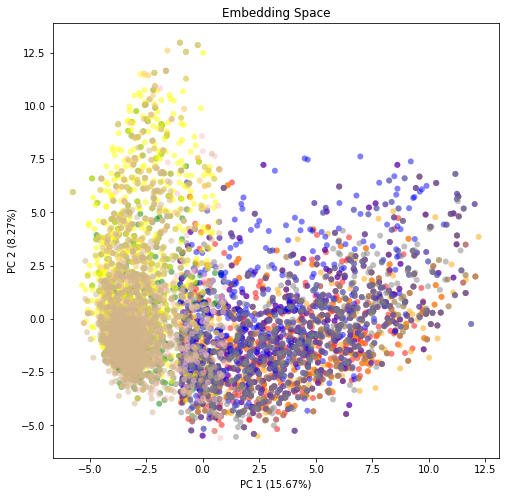

In [21]:
words = vocab_df['word'].tolist()
embeddings = [ast.literal_eval(i) for i in vocab_df['embedding'].tolist()]

eight_label = vocab_df['emotion'].tolist()

visualize_embs(eight_label,embeddings,words)

[2490, 1162, 2675, 2203, 1063, 69, 2128, 2658, 1505, 249, 2657, 462, 120, 2174, 2645, 38, 161, 2637, 385, 2106, 2273, 2638, 2833, 2348, 1571, 119, 1729, 167, 2546, 2492, 1152, 738, 90, 1078, 1116, 201, 1269, 1034, 488, 2697, 2545, 283, 67, 498, 852, 1184, 374, 1247, 2548, 2100]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


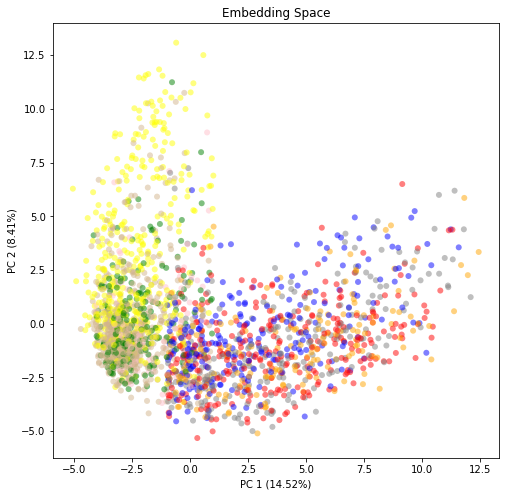

In [ ]:
words = vocab_df['word'].tolist()
embeddings = [ast.literal_eval(i) for i in vocab_df['embedding'].tolist()]

eight_label = vocab_df['emotion'].tolist()

visualize_embs(eight_label,embeddings,words)

In [ ]:
remove = ['bugaboo','omen','lunacy','raving', 'aaaaaaah', 'sonervous', 'egregious','cantbreathe']

vocab_df.reset_index(drop=True,inplace=True)
print(len(remove))

k = 0
for i in range(len(vocab_df)):
  if vocab_df['word'][i] in remove:
    vocab_df = vocab_df.drop(i)
    k+=1

print(k)
print(len(vocab_df))
vocab_df.reset_index(drop=True,inplace=True)

8
1
2861


In [ ]:
vocab_df = vocab_df.loc[vocab_df['emotion'].isin(['anger','fear','disgust','sadness'])]

[597, 1313, 285, 1390, 1080, 1336, 436, 965, 1225, 1418, 1129, 241, 596, 366, 405, 430, 926, 1084, 863, 1176, 51, 1160, 1357, 1137, 554, 642, 659, 813, 1169, 227, 1356, 1424, 968, 502, 1454, 1139, 503, 668, 1455, 234, 27, 922, 1389, 611, 1073, 953, 88, 1314, 231, 451]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


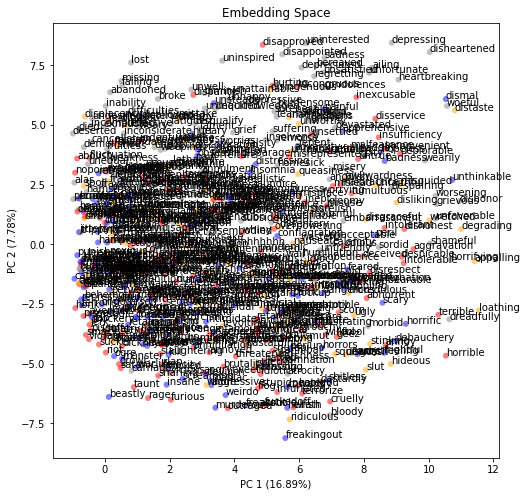

In [ ]:
words = vocab_df['word'].tolist()
embeddings = [ast.literal_eval(i) for i in vocab_df['embedding'].tolist()]

eight_label = vocab_df['emotion'].tolist()

visualize_embs(eight_label,embeddings,words)

In [ ]:
print(vocab_df.groupby('emotion').count())
print(vocab_df.groupby('emotion').sum())

              word  emotion-intensity-score  embedding
emotion                                               
anger          420                      420        420
anticipation   248                      248        248
disgust        256                      256        256
fear           427                      427        427
joy            417                      417        417
sadness        361                      361        361
surprise       136                      136        136
              emotion-intensity-score
emotion                              
anger                         229.504
anticipation                  130.197
disgust                       138.535
fear                          222.386
joy                           231.385
sadness                       188.140
surprise                       80.608


In [ ]:
print(vocab_df.groupby('emotion').count())
print(vocab_df.groupby('emotion').sum())

              word  emotion-intensity-score  embedding
emotion                                               
anger          420                      420        420
anticipation   248                      248        248
disgust        256                      256        256
fear           427                      427        427
joy            417                      417        417
sadness        361                      361        361
surprise       136                      136        136
trust          596                      596        596
              emotion-intensity-score
emotion                              
anger                         229.504
anticipation                  130.197
disgust                       138.535
fear                          222.386
joy                           231.385
sadness                       188.140
surprise                       80.608
trust                         309.727


In [ ]:
eda = vocab_df.copy()
eda = eda.sort_values(by=['word'], ascending = (True))

In [ ]:
eda.head()

,word,emotion,emotion-intensity-score,embedding
4776,aaaaaaah,fear,0.344,"[0.3540674149990082, 0.7942342162132263, 0.423..."
4996,aaaah,fear,0.234,"[0.16953665018081665, 0.48216885328292847, 0.3..."
9524,abacus,trust,0.406,"[-0.3572045564651489, -0.27242910861968994, 0...."
6708,abandon,sadness,0.703,"[-0.33487018942832947, -0.015286496840417385, ..."
4257,abandon,fear,0.531,"[-0.3348705768585205, -0.015286803245544434, -..."


In [ ]:
for i in range(len(vocab_df)):
  if(i%2 == 1):
    eda = eda.drop(i)

In [ ]:
print(vocab_df.groupby('emotion').sum())
# print(eda.groupby('emotion').sum())

              emotion-intensity-score
emotion                              
anger                         230.767
anticipation                  130.197
disgust                       138.535
fear                          225.402
joy                           231.385
sadness                       188.140
surprise                       80.608
trust                         309.727


In [ ]:
print(vocab_df.groupby('emotion').count())
# print(eda.groupby('emotion').count())

              Unnamed: 0  word  emotion-intensity-score  embedding
emotion                                                           
anger                420   420                      420        420
anticipation         248   248                      248        248
disgust              256   256                      256        256
fear                 427   427                      427        427
joy                  417   417                      417        417
sadness              361   361                      361        361
surprise             136   136                      136        136
trust                596   596                      596        596


In [ ]:
eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4961 entries, 4776 to 5786
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word                     4961 non-null   object 
 1   emotion                  4961 non-null   object 
 2   emotion-intensity-score  4961 non-null   float64
 3   embedding                4961 non-null   object 
dtypes: float64(1), object(3)
memory usage: 193.8+ KB


In [ ]:
# sorted(eda['word'])

[1268, 2100, 88, 913, 2251, 1729, 1557, 377, 1853, 185, 2101, 2083, 1663, 1536, 87, 1702, 2247, 1787, 119, 251, 121, 2084, 1554, 839, 1365, 303, 895, 1648, 721, 1234, 557, 1974, 146, 1967, 907, 2015, 873, 995, 2135, 372, 93, 903, 63, 376, 656, 2014, 979, 929, 1643, 2017]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


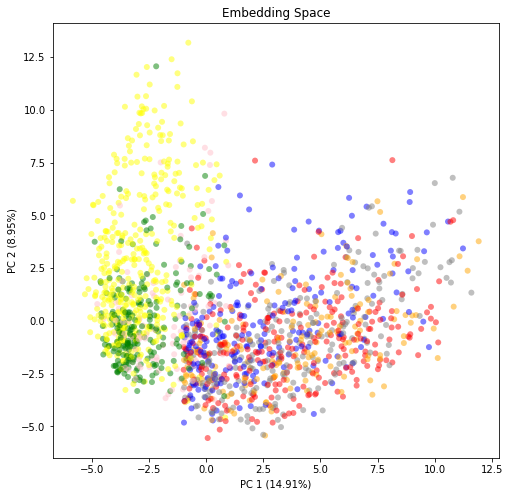

In [ ]:
words = eda['word'].tolist()
# embeddings = eda['embedding'].tolist()
embeddings = [ast.literal_eval(i) for i in eda['embedding'].tolist()]
eight_label = eda['emotion'].tolist()

visualize_embs(eight_label,embeddings,words)

In [ ]:
lda = vocab_df.copy()

In [ ]:
lda = lda.sort_values(by=['word','emotion-intensity-score'], ascending = (True, False))
lda = lda.reset_index(drop=True)

In [ ]:
lda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9921 entries, 0 to 9920
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word                     9921 non-null   object 
 1   emotion                  9921 non-null   object 
 2   emotion-intensity-score  9921 non-null   float64
 3   embedding                9921 non-null   object 
dtypes: float64(1), object(3)
memory usage: 310.2+ KB


In [ ]:
word = lda['word'][0]

for i in range(1,len(lda)):
  if(word == lda['word'][i]):
    lda = lda.drop(i)
  else:
    word = lda['word'][i]
lda = lda.reset_index(drop=True)

In [ ]:
print(len(set(lda['word'])))
lda.info()

2988
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988 entries, 0 to 2987
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word                     2988 non-null   object 
 1   emotion                  2988 non-null   object 
 2   emotion-intensity-score  2988 non-null   float64
 3   embedding                2988 non-null   object 
dtypes: float64(1), object(3)
memory usage: 93.5+ KB


In [ ]:
for i in range(len(lda)):
  if(i%2 == 1):
    lda = lda.drop(i)
lda = lda.reset_index(drop=True)

In [ ]:
# sorted(lda['word'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


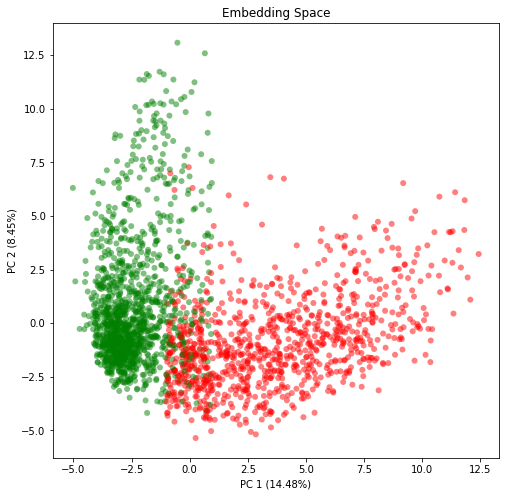

In [ ]:
words = lda['word'].tolist()
# embeddings = lda['embedding'].tolist()
embeddings = [ast.literal_eval(i) for i in lda['embedding'].tolist()]
eight_label = lda['emotion'].tolist()

visualize_embs(eight_label,embeddings,words)

In [ ]:
emotion = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness','surprise', 'trust']

def compute_ratio(early_count,modified_count,early_sum,modified_sum):
  emotion_dict_count = {'anticipation':0,'anger':0,'fear':0,'sadness':0,'trust':0,'joy':0,'surprise':0,'disgust':0}
  emotion_dict_sum = {'anticipation':0,'anger':0,'fear':0,'sadness':0,'trust':0,'joy':0,'surprise':0,'disgust':0}
  for emo in range(8):
    emotion_dict_count[emotion[emo]] = round(modified_count['emotion-intensity-score'][emo] / 2888,2)*100
    emotion_dict_sum[emotion[emo]] = round(modified_sum['emotion-intensity-score'][emo] / early_sum['emotion-intensity-score'][emo],2)*100
  print('Emotion word count')
  print(emotion_dict_count)
  print('Emotion intensity score sum')
  print(emotion_dict_sum)

In [ ]:
early_count = vocab_df.groupby('emotion').count()
early_sum = vocab_df.groupby('emotion').sum()

modified_count = lda.groupby('emotion').count()
modified_sum = lda.groupby('emotion').sum()
compute_ratio(early_count,modified_count,early_sum,modified_sum)

Emotion word count
{'anticipation': 9.0, 'anger': 15.0, 'fear': 15.0, 'sadness': 13.0, 'trust': 21.0, 'joy': 15.0, 'surprise': 5.0, 'disgust': 9.0}
Emotion intensity score sum
{'anticipation': 31.0, 'anger': 31.0, 'fear': 26.0, 'sadness': 28.999999999999996, 'trust': 40.0, 'joy': 37.0, 'surprise': 28.000000000000004, 'disgust': 25.0}


In [ ]:
print(lda.groupby('emotion').count())
print(lda.groupby('emotion').sum())

              word  emotion-intensity-score  embedding
emotion                                               
anger          422                      422        422
anticipation   248                      248        248
disgust        256                      256        256
fear           433                      433        433
joy            417                      417        417
sadness        361                      361        361
surprise       136                      136        136
trust          596                      596        596
              emotion-intensity-score
emotion                              
anger                         230.767
anticipation                  130.197
disgust                       138.535
fear                          225.402
joy                           231.385
sadness                       188.140
surprise                       80.608
trust                         309.727


In [ ]:
lda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 0 to 2987
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word                     2869 non-null   object 
 1   emotion                  2869 non-null   object 
 2   emotion-intensity-score  2869 non-null   float64
 3   embedding                2869 non-null   object 
dtypes: float64(1), object(3)
memory usage: 192.1+ KB


In [ ]:
emotion = ['fear', 'trust', 'sadness', 'disgust', 'anger', 'surprise', 'joy','anticipation']
qwe = pd.DataFrame(columns=['word', 'emotion-intensity-score', 'embedding'])

for i in emotion:
  dda = lda.copy()
  print(i)
  dda = dda.loc[dda['emotion']== i]
  dda = dda.sort_values(by=['emotion-intensity-score'], ascending = (False))
  dda.reset_index(drop=True,inplace=True)
  for j in range(len(dda)):
    if(j >= 150):
      dda = dda.drop(j)
  qwe = qwe.append(dda, ignore_index=True)


fear
trust
sadness
disgust
anger
surprise
joy
anticipation


In [ ]:
emotion = ['fear', 'trust', 'sadness', 'disgust', 'anger', 'surprise', 'joy','anticipation']
dfa = pd.DataFrame(columns=['word', 'emotion-intensity-score', 'embedding'])

for i in emotion:
  dda = lda.copy()
  print(i)
  dda = dda.loc[dda['emotion']== i]
  dda = dda.sort_values(by=['emotion-intensity-score'], ascending = (False))
  dda.reset_index(drop=True,inplace=True)
  for j in range(len(dda)):
    if(dda['emotion-intensity-score'][j] < 0.5):
      dda = dda.drop(j)
  dfa = dfa.append(dda, ignore_index=True)

fear
trust
sadness
disgust
anger
surprise
joy
anticipation


In [ ]:
print(qwe.groupby('emotion').count())
print(qwe.groupby('emotion').sum())

              word  emotion-intensity-score  embedding
emotion                                               
anger          150                      150        150
anticipation   150                      150        150
disgust        150                      150        150
fear           150                      150        150
joy            150                      150        150
sadness        150                      150        150
surprise       136                      136        136
trust          150                      150        150
              emotion-intensity-score
emotion                              
anger                         114.571
anticipation                   90.628
disgust                        99.940
fear                          114.037
joy                           117.986
sadness                       108.543
surprise                       80.608
trust                         104.117


In [ ]:
print(dfa.groupby('emotion').count())
print(dfa.groupby('emotion').sum())

              word  emotion-intensity-score  embedding
emotion                                               
anger          253                      253        253
anticipation   152                      152        152
disgust        150                      150        150
fear           233                      233        233
joy            261                      261        261
sadness        203                      203        203
surprise        95                       95         95
trust          337                      337        337
              emotion-intensity-score
emotion                              
anger                         171.751
anticipation                   92.011
disgust                       100.144
fear                          161.382
joy                           183.653
sadness                       137.846
surprise                       64.150
trust                         208.395


In [ ]:
import numpy as np
def visualize_embs(labels,embs,words):
    label_color_dict = {'anticipation':'lime','anger':'red','disgust':'olive',
                        'fear':'blue','sadness':'black','joy':'yellow','surprise':'violet',
                        'trust':'mediumturquoise'}

    # label_color_dict = {'anticipation':'green','anger':'red','disgust':'red',
    #                     'fear':'red','sadness':'red','joy':'green','surprise':'green',
    #                     'trust':'green'}
    X = embs
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    # print(result)

    filtered_words = []
    filtered_emb = []
    filtered_label = []
    for i,j in enumerate(result):
        if(j[0] < 1 and labels[i] in ['joy','anticipation','trust','surprise','input']):
            filtered_emb.append(j)
            filtered_label.append(labels[i])
    
            filtered_words.append(words[i])
    
        if (j[0] > -1 and labels[i] in ['sadness','disgust','anger','fear','input']):
            filtered_emb.append(j)
            filtered_label.append(labels[i])
            filtered_words.append(words[i])

    result = np.array([x for x in filtered_emb])
    labels = filtered_label
    words = filtered_words
    # print(result)

    cvec = [label_color_dict[label] for label in labels]


    # Create the scatter plot
    plt.figure(figsize=(8,8))
    plt.scatter(result[:,0], result[:,1],c=cvec, edgecolor='', alpha=0.5)

    annotations= words
    X = result[:,0]
    Y = result[:,1]

    # for i, label in enumerate(annotations):
    #   plt.annotate(label, (X[i], Y[i]))

    # Add the axis labels
    plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
    plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100))
    plt.title('Embedding Space')
    # Done
    plt.show()

In [ ]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word                     1684 non-null   object 
 1   emotion-intensity-score  1684 non-null   float64
 2   embedding                1684 non-null   object 
 3   emotion                  1684 non-null   object 
dtypes: float64(1), object(3)
memory usage: 52.8+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


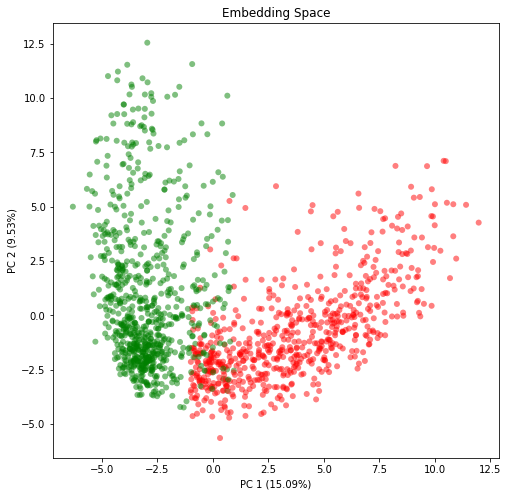

In [ ]:
words = dfa['word'].tolist()
# embeddings = lda['embedding'].tolist()
embeddings = [ast.literal_eval(i) for i in dfa['embedding'].tolist()]
eight_label = dfa['emotion'].tolist()

visualize_embs(eight_label,embeddings,words)

In [ ]:
qwe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word                     1186 non-null   object 
 1   emotion-intensity-score  1186 non-null   float64
 2   embedding                1186 non-null   object 
 3   emotion                  1186 non-null   object 
dtypes: float64(1), object(3)
memory usage: 37.2+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


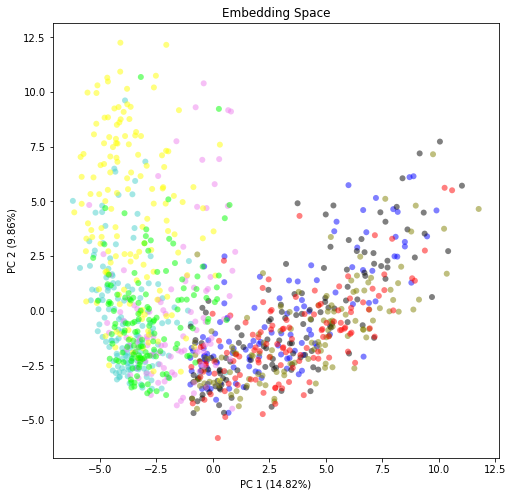

In [ ]:
words = qwe['word'].tolist()
# embeddings = lda['embedding'].tolist()
embeddings = [ast.literal_eval(i) for i in qwe['embedding'].tolist()]
eight_label = qwe['emotion'].tolist()

visualize_embs(eight_label,embeddings,words)

In [ ]:
remove = ['craps','shyt','panicked','tan','lml','regretful','regrettable','nap','troubles','untuk','sur','rota','pith','wot','symptom','toothache','gash','viper','assassin','betrothed','mentor','obstetrician','pedigree','title',
          'hairclip','tree','roadster','gon','comatose','wounded','paralysis','don','sist','urs','cashier','calculator','fireman','clapping','absentee','uneducated','landmark','exhaustive','losing','gambler','hap','creeping',
          'endless','commerce','dreamt','monogamy','priesthood','heritage','athlete','cess','laughing','gladness','anticipatory','child','salary','giggling','happy','enthusiasm','yaaay','smiles','lovelife','xmas','nullify',
          'modify','hate','ulcer','malaria','disappointment','sad','marriage','scared','fearfully','lovee','bridal','bridegroom','swim','infant','basketball','banquet','tea','sand','peppermint','foodie','thief','fucksake',
          'madman','cholera','herpesvirus','gonorrhea','pocketbac','digit','mandamus','carnivorous','scalpel','anthrax','guerilla','lesbians','serve','puff','fuse','inefficiency','lightning','serpent','shrapnel','hemorrhage',
          'christmastime','happyvalentinesday','celebrated','retirement','applicant','delivery','measles','euthanasia','malignancy','tumour']

lda.reset_index(drop=True,inplace=True)
print(len(remove))

k = 0
for i in range(len(lda)):
  if lda['word'][i] in remove:
    lda = lda.drop(i)
    k+=1

print(k)
print(len(lda))

119
119
2869


In [ ]:
vocab_df.loc[vocab_df['emotion'] == 'trust']

,word,emotion,emotion-intensity-score,embedding


In [ ]:
vocab_df.loc[vocab_df['word'].isin(['relief', 'nostalgic', 'fulfilling'])]

,word,emotion,emotion-intensity-score,embedding
1074,fulfilling,joy,0.618,"[-0.14413057267665863, -0.8849706649780273, 0...."
1752,nostalgic,joy,0.439,"[-0.3804325461387634, 0.43222492933273315, -0...."
2115,relief,joy,0.438,"[-1.275506854057312, 0.39340507984161377, -0.3..."


In [ ]:
# fear : panic, frightful, wrenching, dismal, distress
# trust : approve, accepted, witness, neutral
# sadness : embarrassment, despairing, sorrowful, tearful, wail, mournful
# disgust : appalling, loathing, hideous, disgust
# anger : furious, outraged ,annoy, disrespect 
# surprise : stun, vanish, ambush 
# joy : relief, nostalgic, fulfilling
# anticipation : lookout, anticipate, predict, approaching

fear
[303, 401, 405, 398, 304, 224, 111, 183, 419, 146, 0, 11, 141, 330, 176, 96, 306, 255, 314, 24, 115, 272, 375, 422, 101, 423, 416, 142, 127, 108, 95, 150, 270, 278, 412, 381, 404, 342, 387, 92, 104, 327, 236, 253, 172, 130, 5, 403, 312, 58]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


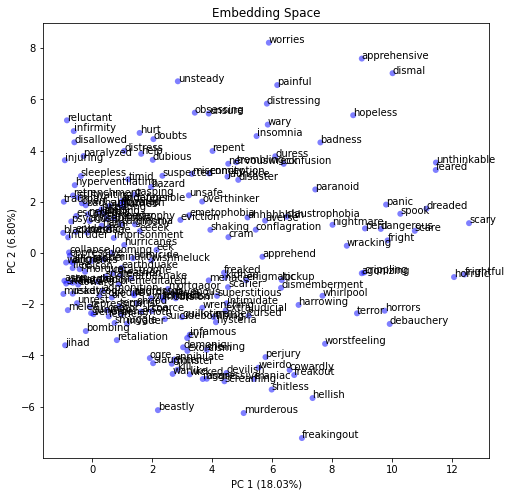

trust
[164, 584, 542, 283, 298, 143, 292, 271, 575, 297, 106, 152, 348, 381, 492, 3, 32, 413, 586, 188, 101, 350, 204, 563, 322, 211, 247, 214, 527, 456, 478, 360, 562, 595, 123, 578, 233, 71, 291, 24, 377, 483, 471, 36, 83, 566, 505, 137, 307, 569]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


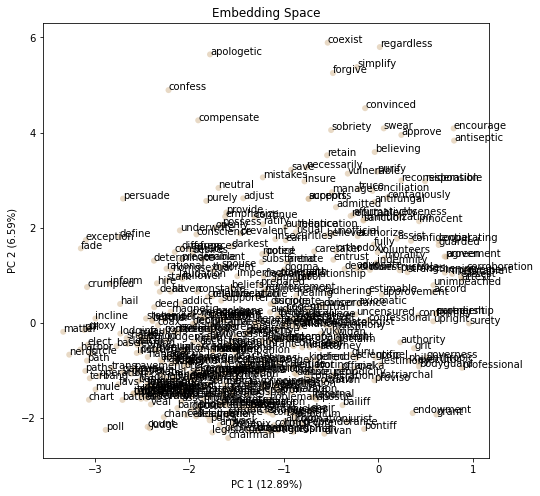

sadness
[326, 305, 123, 344, 135, 168, 35, 27, 293, 336, 54, 197, 52, 233, 14, 270, 307, 106, 9, 243, 219, 188, 162, 201, 227, 332, 108, 231, 15, 183, 331, 333, 18, 62, 346, 285, 282, 124, 319, 33, 357, 181, 179, 283, 242, 169, 266, 246, 313, 129]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


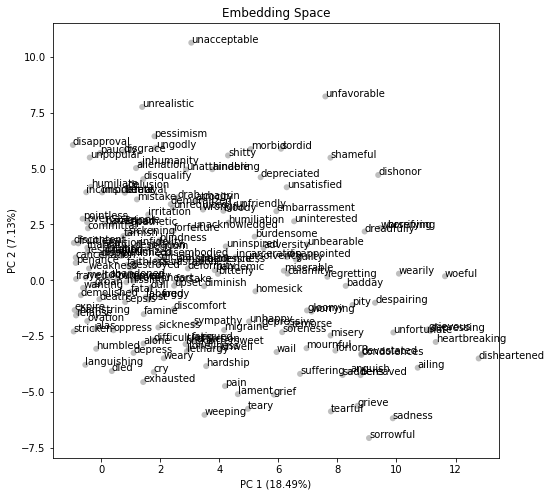

disgust
[148, 14, 63, 38, 173, 47, 145, 246, 204, 54, 203, 252, 120, 189, 35, 98, 96, 106, 99, 109, 48, 159, 139, 6, 36, 185, 184, 186, 5, 243, 105, 101, 25, 56, 126, 178, 129, 199, 179, 187, 117, 202, 190, 27, 158, 66, 201, 110, 7, 10]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


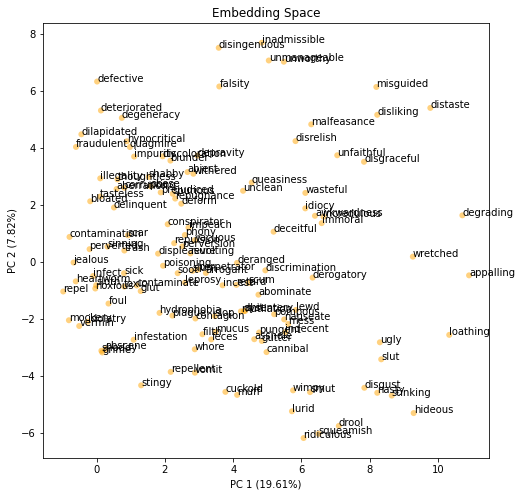

anger
[402, 6, 260, 173, 64, 76, 200, 18, 9, 21, 217, 149, 205, 115, 230, 272, 378, 274, 114, 216, 401, 415, 416, 85, 222, 167, 12, 172, 147, 259, 258, 317, 334, 297, 140, 20, 152, 136, 387, 22, 389, 386, 208, 102, 283, 35, 249, 202, 377, 82]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


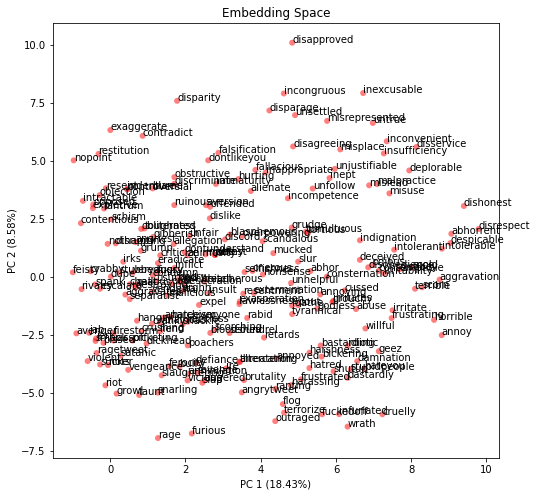

surprise
[50, 44, 92, 124, 31, 122, 37, 80, 103, 65, 16, 35, 43, 115, 97, 119, 74, 28, 98, 8, 95, 133, 33, 3, 112, 36, 1, 121, 101, 49, 117, 120, 89, 60, 84, 106, 58, 110, 39, 134, 4, 27, 73, 78, 71, 57, 131, 41, 62, 64]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


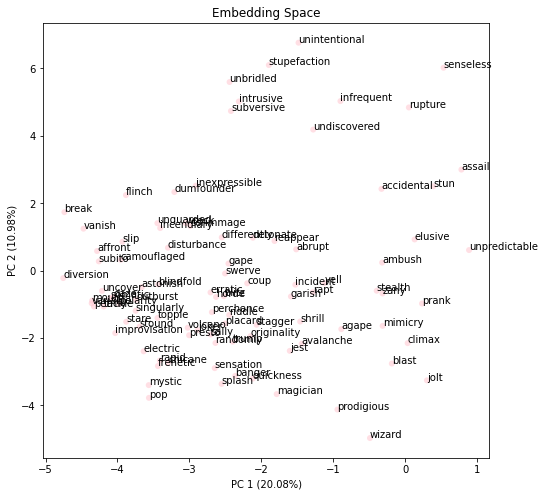

joy
[410, 282, 414, 123, 184, 214, 275, 51, 77, 6, 85, 385, 394, 176, 283, 350, 5, 226, 413, 163, 224, 152, 382, 387, 326, 314, 327, 268, 115, 366, 222, 293, 225, 269, 239, 272, 345, 29, 372, 170, 371, 189, 308, 8, 267, 182, 137, 374, 82, 388]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


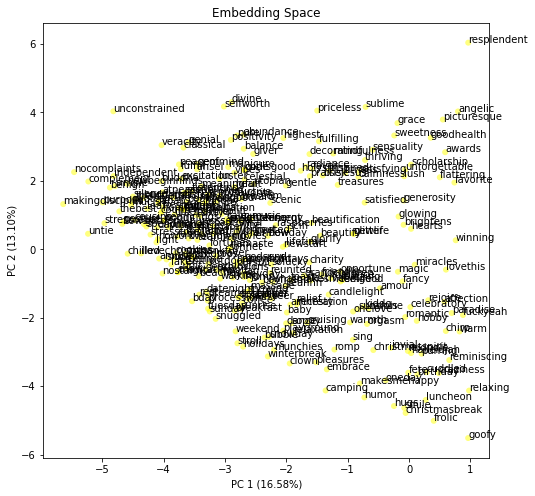

anticipation
[134, 6, 184, 50, 247, 91, 2, 226, 98, 161, 42, 84, 201, 217, 139, 206, 10, 126, 239, 227, 229, 231, 232, 65, 219, 222, 104, 224, 153, 9, 244, 221, 163, 243, 112, 43, 159, 33, 32, 137, 102, 51, 96, 123, 48, 132, 97, 20, 23, 125]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


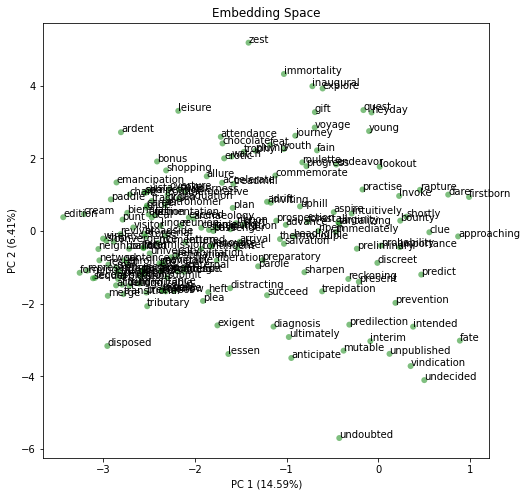

In [ ]:
emotion = ['fear', 'trust', 'sadness', 'disgust', 'anger', 'surprise', 'joy','anticipation']

for i in emotion:
  dda = vocab_df.copy()
  print(i)
  dda = dda.loc[dda['emotion']== i]
  words = dda['word'].tolist()
  # embeddings = lda['embedding'].tolist()
  embeddings = [ast.literal_eval(i) for i in dda['embedding'].tolist()]
  eight_label = dda['emotion'].tolist()

  visualize_embs(eight_label,embeddings,words)

In [ ]:
lda.loc[lda['word']== 'euthanasia']

,word,emotion,emotion-intensity-score,embedding
906,euthanasia,sadness,0.927,"[0.4564814567565918, 0.02287476696074009, -0.8..."


#Emo Lex

In [ ]:
dfff = pd.read_csv(r"/content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Resources/NRC-Emotion-Lexicon.csv")
dfff.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
dfff.rename(columns = {'Words':'word'}, inplace = True)

In [ ]:
dfff.dropna(inplace=True)

In [ ]:
dfff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14181 entries, 0 to 14181
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   word          14181 non-null  object
 1   Positive      14181 non-null  int64 
 2   Negative      14181 non-null  int64 
 3   Anger         14181 non-null  int64 
 4   Anticipation  14181 non-null  int64 
 5   Disgust       14181 non-null  int64 
 6   Fear          14181 non-null  int64 
 7   Joy           14181 non-null  int64 
 8   Sadness       14181 non-null  int64 
 9   Surprise      14181 non-null  int64 
 10  Trust         14181 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 1.3+ MB


In [ ]:
dfff.head()

,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,aback,0,0,0,0,0,0,0,0,0,0
1,abacus,0,0,0,0,0,0,0,0,0,1
2,abandon,0,1,0,0,0,1,0,1,0,0
3,abandoned,0,1,1,0,0,1,0,1,0,0
4,abandonment,0,1,1,0,0,1,0,1,1,0


In [ ]:
xda = vocab_df.copy()
xda = xda.sort_values(by=['word','emotion-intensity-score'], ascending = (True, False))
xda = xda.reset_index(drop=True)

In [ ]:
word = xda['word'][0]

for i in range(1,len(xda)):
  if(word == xda['word'][i]):
    xda = xda.drop(i)
  else:
    word = xda['word'][i]

xda = xda.reset_index(drop=True)

In [ ]:
for i in range(len(xda)):
  if(i%2 == 1):
    xda = xda.drop(i)

xda = xda.reset_index(drop=True)

In [ ]:
xda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988 entries, 0 to 2987
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word                     2988 non-null   object 
 1   emotion                  2988 non-null   object 
 2   emotion-intensity-score  2988 non-null   float64
 3   embedding                2988 non-null   object 
dtypes: float64(1), object(3)
memory usage: 93.5+ KB


In [ ]:
list2 = list(set(xda.word) & set(dfff.word))
print(len(list2))

2412


In [ ]:
final_df = xda.loc[xda['word'].isin(list2)]
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2412 entries, 1 to 2987
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word                     2412 non-null   object 
 1   emotion                  2412 non-null   object 
 2   emotion-intensity-score  2412 non-null   float64
 3   embedding                2412 non-null   object 
dtypes: float64(1), object(3)
memory usage: 94.2+ KB


In [ ]:
final = pd.merge(final_df, dfff, on='word', how='inner')
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2412 entries, 0 to 2411
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word                     2412 non-null   object 
 1   emotion                  2412 non-null   object 
 2   emotion-intensity-score  2412 non-null   float64
 3   embedding                2412 non-null   object 
 4   Positive                 2412 non-null   int64  
 5   Negative                 2412 non-null   int64  
 6   Anger                    2412 non-null   int64  
 7   Anticipation             2412 non-null   int64  
 8   Disgust                  2412 non-null   int64  
 9   Fear                     2412 non-null   int64  
 10  Joy                      2412 non-null   int64  
 11  Sadness                  2412 non-null   int64  
 12  Surprise                 2412 non-null   int64  
 13  Trust                    2412 non-null   int64  
dtypes: float64(1), int64(10)

In [ ]:
final = final[['word','emotion','emotion-intensity-score','embedding','Positive','Negative']]

In [ ]:
final.head()

,word,emotion,emotion-intensity-score,embedding,Positive,Negative
0,abacus,trust,0.406,"[-0.3572045564651489, -0.27242910861968994, 0....",0,0
1,abandoned,sadness,0.828,"[-0.5577418804168701, 0.015890369191765785, -0...",0,1
2,abbot,trust,0.438,"[-0.5629075765609741, -0.4061563313007355, -0....",0,0
3,aberration,disgust,0.531,"[-0.5287905931472778, -0.1950991153717041, -0....",0,1
4,abhor,anger,0.816,"[-0.6878913640975952, 0.1946220099925995, -1.3...",0,1


In [ ]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2412 entries, 0 to 2411
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word                     2412 non-null   object 
 1   emotion                  2412 non-null   object 
 2   emotion-intensity-score  2412 non-null   float64
 3   embedding                2412 non-null   object 
 4   Positive                 2412 non-null   int64  
 5   Negative                 2412 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 131.9+ KB


In [ ]:
# sorted(final.word)

In [ ]:
test = final.loc[(final['Positive'] == 0) & (final['Negative'] == 0)]
print(test.groupby('emotion').count())
# print(test.groupby('Negative').count())


              word  emotion-intensity-score  Positive  Negative
emotion                                                        
anger           28                       28        28        28
anticipation   115                      115       115       115
disgust         27                       27        27        27
fear            84                       84        84        84
joy             44                       44        44        44
sadness         40                       40        40        40
surprise        60                       60        60        60
trust          184                      184       184       184


In [ ]:
final.groupby('emotion').count()

,word,emotion-intensity-score,embedding,Positive,Negative
emotion,,,,,
anger,322,322,322,322,322
anticipation,260,260,260,260,260
disgust,249,249,249,249,249
fear,347,347,347,347,347
joy,238,238,238,238,238
sadness,336,336,336,336,336
surprise,123,123,123,123,123
trust,537,537,537,537,537


In [ ]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2412 entries, 0 to 2411
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word                     2412 non-null   object 
 1   emotion                  2412 non-null   object 
 2   emotion-intensity-score  2412 non-null   float64
 3   embedding                2412 non-null   object 
 4   Positive                 2412 non-null   int64  
 5   Negative                 2412 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 211.9+ KB


In [ ]:
final['embedding'] = [ast.literal_eval(i) for i in final['embedding'].tolist()]

In [ ]:
# indices = [890, 2396, 917, 2355, 2100, 1869, 2263, 2107, 992, 756, 1675, 1804, 93, 2250, 2249, 103, 1280, 2230, 331, 1937, 2231, 102, 397, 1787, 1845, 138, 1472, 1337, 33, 143, 642, 2108, 173, 77, 1281, 1080, 986, 926, 894, 957, 237, 2154, 59, 433, 738, 1010, 319, 1780, 1781, 1063]
# for i in range (len(indices)):
#   final = final.drop(i)

# final = final.reset_index(drop=True)

[890, 2396, 917, 2355, 2100, 1869, 2263, 2107, 992, 756, 1675, 1804, 93, 2250, 2249, 103, 1280, 2230, 331, 1937, 2231, 102, 397, 1787, 1845, 138, 1472, 1337, 33, 143, 642, 2108, 173, 77, 1281, 1080, 986, 926, 894, 957, 237, 2154, 59, 433, 738, 1010, 319, 1780, 1781, 1063]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


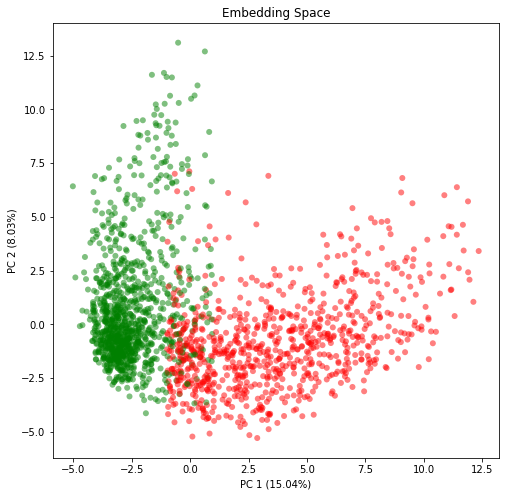

In [ ]:
words = final['word'].tolist()
embeddings = final['embedding'].tolist()
# embeddings = [ast.literal_eval(i) for i in final['embedding'].tolist()]
eight_label = final['emotion'].tolist()

visualize_embs(eight_label,embeddings,words)

In [ ]:
tuples = []
need_to_remove = []

positive = ['joy','anticipation','trust','surprise']
negative = ['sadness','disgust','anger','fear']

for j,row_d in final.iterrows():
  print()
  print(j)
  indexes, distances = t.get_nns_by_vector(row_d['embedding'], 2, include_distances=True)
  for i in range(len(indexes)):
    tuples.append([[indexes[i]],final['emotion'][indexes[i]],distances[i],final['embedding'][indexes[i]]])
  
  s_tup = sorted(tuples, key=lambda x: x[2])

  print(row_d['emotion'])
  for k,m in enumerate(s_tup[::-1]):
    print(m[1])
    if(((m[1] in positive) and (row_d['emotion'] in negative)) or ((m[1] in negative) and (row_d['emotion'] in positive))):
      need_to_remove.append(row_d.index)
      break

Streaming output truncated to the last 5000 lines.
trust
surprise
anticipation
trust
disgust

1307
disgust
joy

1308
trust
joy
trust
surprise
anticipation
trust
disgust

1309
joy
joy
trust
surprise
anticipation
trust
disgust

1310
joy
joy
trust
surprise
anticipation
trust
disgust

1311
fear
joy

1312
anger
joy

1313
anticipation
joy
trust
surprise
anticipation
trust
disgust

1314
fear
joy

1315
anger
joy

1316
anger
joy

1317
anger
anger
joy

1318
disgust
anger
joy

1319
anticipation
anger

1320
fear
anger
joy

1321
trust
anger

1322
sadness
anger
joy

1323
sadness
anger
joy

1324
anticipation
anger

1325
anticipation
anger

1326
fear
anger
joy

1327
trust
anger

1328
sadness
anger
joy

1329
sadness
anger
joy

1330
anger
anger
joy

1331
disgust
anger
joy

1332
joy
anger

1333
joy
anger

1334
sadness
anger
joy

1335
sadness
anger
joy

1336
trust
anger

1337
anticipation
anger

1338
joy
anger

1339
anticipation
anger

1340
fear
anger
joy

1341
joy
anger

1342
disgust
anger
joy

1343
joy


In [ ]:
len(need_to_remove)

2412

In [ ]:
flat_list = [item for sublist in need_to_remove for item in sublist]
final_list = list(set(flat_list))

In [ ]:
len(final_list)

2411

In [ ]:
for i in range(len(final_list)):
  final = final.drop(i)

final = final.reset_index(drop=True)

#Creating Annoy Index

In [ ]:
import pandas as pd

dff = pd.read_csv(r"/content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Resources/NRC Emotion Intensity_V3.csv")
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9921 entries, 0 to 9920
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word                     9921 non-null   object 
 1   emotion                  9921 non-null   object 
 2   emotion-intensity-score  9921 non-null   float64
 3   embedding                9921 non-null   object 
dtypes: float64(1), object(3)
memory usage: 310.2+ KB


In [ ]:
vocab_df = vocab_df.loc[:, ~vocab_df.columns.str.contains('^Unnamed')]

In [ ]:
dff = vocab_df

In [ ]:
dff = dff.reset_index(drop=True)

In [ ]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2265 entries, 0 to 2264
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word                     2265 non-null   object 
 1   emotion                  2265 non-null   object 
 2   emotion-intensity-score  2265 non-null   float64
 3   embedding                2265 non-null   object 
dtypes: float64(1), object(3)
memory usage: 70.9+ KB


In [ ]:
dff.head()

,word,emotion,emotion-intensity-score,embedding
0,abandoned,sadness,0.828,"[-0.5577418804168701, 0.015890369191765785, -0..."
1,aberration,disgust,0.531,"[-0.5287905931472778, -0.1950991153717041, -0...."
2,abhor,anger,0.816,"[-0.6878913640975952, 0.1946220099925995, -1.3..."
3,abhorrent,anger,0.875,"[-0.3238641023635864, 0.3315010368824005, -1.2..."
4,abject,disgust,0.438,"[-0.7886091470718384, 0.3905762732028961, -1.1..."


In [ ]:
import ast

dff['embedding'] = [ast.literal_eval(i) for i in dff['embedding'].values.tolist()]
dff.head()

,word,emotion,emotion-intensity-score,embedding
0,abandoned,sadness,0.828,"[-0.5577418804168701, 0.015890369191765785, -0..."
1,aberration,disgust,0.531,"[-0.5287905931472778, -0.1950991153717041, -0...."
2,abhor,anger,0.816,"[-0.6878913640975952, 0.1946220099925995, -1.3..."
3,abhorrent,anger,0.875,"[-0.3238641023635864, 0.3315010368824005, -1.2..."
4,abject,disgust,0.438,"[-0.7886091470718384, 0.3905762732028961, -1.1..."


In [ ]:
word_embeddings = dff['embedding']

In [ ]:
print(len(word_embeddings))
print(len(word_embeddings[0]))

2265
768


In [ ]:
! pip install annoy -q

In [ ]:
from annoy import AnnoyIndex

f = 768
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
for i in range(len(word_embeddings)):
    t.add_item(i, word_embeddings[i])

t.build(500) # 500 trees

t.save(r"/content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Resources/NRC-Modified-Without-Trust.ann")

True

In [ ]:
t.get_n_items()

2265

In [ ]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2265 entries, 0 to 2264
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   word                     2265 non-null   object 
 1   emotion                  2265 non-null   object 
 2   emotion-intensity-score  2265 non-null   float64
 3   embedding                2265 non-null   object 
dtypes: float64(1), object(3)
memory usage: 70.9+ KB


In [ ]:
dff.to_csv(r"/content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Resources/NRC-Modified-Without-Trust.csv",index =False)